In [1]:
# https://evizero.github.io/Augmentor.jl/generated/mnist_elastic/

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
from tqdm import tqdm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os

import torch
from torch import optim
from torchvision import  transforms

from sklearn.model_selection import ParameterGrid

import tensorlayer.prepro as prepro

from lib.classifier import *
from lib.utils import *
from lib.models import MNIST_TPN
from lib.task import load_data

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-25 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 61%


In [3]:
SEED=0
np.random.seed(SEED)

In [4]:
class ToNumpy(object):
    def __call__(self, arr):
        return np.array(arr)
    def __repr__(self):
        return self.__class__.__name__ + '()'

class ToItem(object):
    def __call__(self, val):
        return val.item()
    def __repr__(self):
        return self.__class__.__name__ + '()'
    
image_transform = transforms.Compose([
        ToNumpy()
    ])

target_transform = transforms.Compose([
        ToItem()
    ])

dataset = list(MNIST('./data', dataset="train", download=True, 
                     transform=image_transform, target_transform=target_transform))

X_train, y_train = zip(*dataset)
X_train, y_train = np.array(X_train), np.array(y_train)
img = X_train[0]

<IPython.core.display.Javascript object>


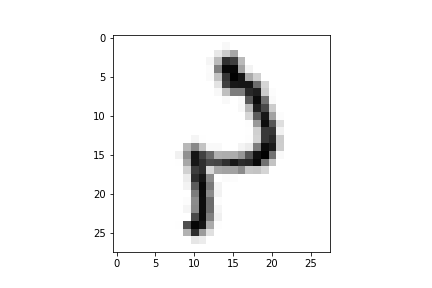

interactive(children=(IntSlider(value=4, description='char', max=9), IntSlider(value=50, description='idx'), IntSlider(value=0, description='x', max=90, min=-90), Output()), _dom_classes=('widget-interact',))

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(img.reshape(28,28), cmap='binary')

@interact(char=(0,9), idx=(0,100), x=(-90,90))
def rotate(char, idx, x):
    label_idx = y_train == char
    img = X_train[label_idx][idx]
    
    img_out = prepro.rotation(img.reshape(1, 28, 28), x, is_random=False, row_index=1, col_index=2, channel_index=0)
    im.set_data(img_out.reshape(28,28))

<IPython.core.display.Javascript object>


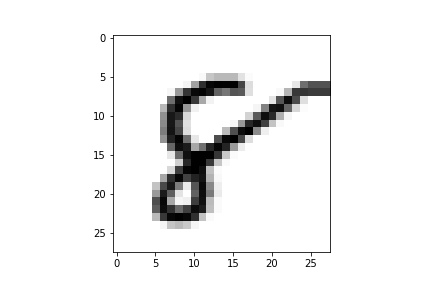

interactive(children=(IntSlider(value=4, description='char', max=9), IntSlider(value=50, description='idx'), FloatSlider(value=0.0, description='wrg', max=0.1, min=-0.1), FloatSlider(value=0.0, description='hrg', max=0.1, min=-0.1), Output()), _dom_classes=('widget-interact',))

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(img.reshape(28,28), cmap='binary')

@interact(char=(0,9), idx=(0,100), wrg=(-0.1,0.1), hrg=(-0.1,0.1))
def shift(char, idx, wrg, hrg):
    label_idx = y_train == char
    img = X_train[label_idx][idx]
    
    img_out = prepro.shift(img.reshape(1, 28, 28), wrg, hrg, is_random=False, row_index=1, col_index=2, channel_index=0)
    im.set_data(img_out.reshape(28,28))

<IPython.core.display.Javascript object>


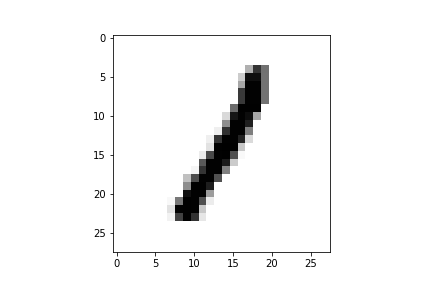

interactive(children=(IntSlider(value=4, description='char', max=9), IntSlider(value=50, description='idx'), FloatSlider(value=0.25, description='intensity', max=0.5), Output()), _dom_classes=('widget-interact',))

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(img.reshape(28,28), cmap='binary')

@interact(char=(0,9), idx=(0,100), intensity=(0.0,0.5))
def shear(char, idx, intensity):
    label_idx = y_train == char
    img = X_train[label_idx][idx]
    
    img_out = prepro.shear(img.reshape(1, 28, 28), intensity=intensity, is_random=False, row_index=1, col_index=2, channel_index=0)
    im.set_data(img_out.reshape(28,28))

<IPython.core.display.Javascript object>


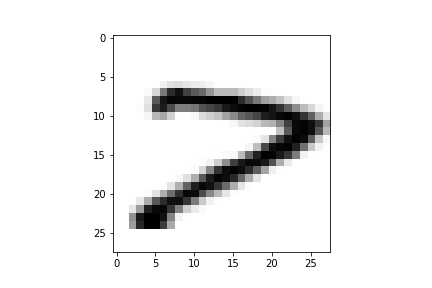

interactive(children=(IntSlider(value=4, description='char', max=9), IntSlider(value=50, description='idx'), FloatSlider(value=1.0, description='x', max=1.1, min=0.9), FloatSlider(value=1.05, description='y', max=1.3, min=0.8), Output()), _dom_classes=('widget-interact',))

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(img.reshape(28,28), cmap='binary')

@interact(char=(0,9), idx=(0,100), x=(0.9,1.1), y=(0.8,1.3))
def zoom(char, idx, x, y):
    label_idx = y_train == char
    img = X_train[label_idx][idx]
    
    img_out = prepro.zoom(img.reshape(1, 28, 28), (x, y), is_random=False, row_index=1, col_index=2, channel_index=0)
    im.set_data(img_out.reshape(28,28))

<IPython.core.display.Javascript object>


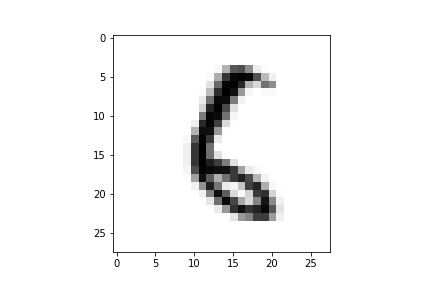

interactive(children=(IntSlider(value=4, description='char', max=9), IntSlider(value=50, description='idx'), IntSlider(value=35, description='alpha', max=50, min=20), FloatSlider(value=5.5, description='sigma', max=7.0, min=4.0), Output()), _dom_classes=('widget-interact',))

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(img.reshape(28,28), cmap='binary')

@interact(char=(0,9), idx=(0,100), alpha=(20,50), sigma=(4.0,7.0))
def elastic_transform(char, idx, alpha, sigma):
    label_idx = y_train == char
    img = X_train[label_idx][idx]
    
    img_out = prepro.elastic_transform(img.reshape(28, 28), alpha=alpha, sigma=sigma, cval=0.0)
    im.set_data(img_out.reshape(28,28))